#DATASCI W261: Machine Learning at Scale

**Nick Hamlin** (nickhamlin@gmail.com)  
**Tigi Thomas** (tgthomas@berkeley.edu)  
**Rock Baek** (rockb1017@gmail.com)  
**Hussein Danish** (husseindanish@gmail.com)  
  
Time of Submission: 10:20 AM EST, Saturday, March 19, 2016  
W261-3, Spring 2016  
Week 9 Homework

###Submission Notes:
- For each problem, we've included a summary of the question as posed in the instructions.  In many cases, we have not included the full text to keep the final submission as uncluttered as possible.  For reference, we've included a link to the original instructions in the "Useful Reference" below.
- Some aspects of this notebook don't always render nicely into PDF form.  In these situations, please reference [the complete rendered notebook on Github](https://github.com/nickhamlin/mids_261_homework/blob/master/HW9/MIDS-W261-2015-HWK-Week09-Hamlin-Thomas-Baek-Danish.ipynb)


###Useful References and Notebook Setup:
- **[Original Assignment Instructions](https://www.dropbox.com/s/wp4cz1e0bif1k76/HW9-Assignment.txt?dl=0)**
- [Raw data on Dropbox](https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)
- [PageRank in Wikipedia](https://en.wikipedia.org/wiki/PageRank)  
- [Topic-Specific PageRank](http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf)


In [1]:
#Use this to make sure we reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2
#Render matplotlib charts in notebook
%matplotlib inline

#Import some modules we know we'll use frequently
import numpy as np
import pylab as plt

In [3]:
#Use this line of code to kick off a persistent cluster
#!python -m mrjob.tools.emr.create_job_flow '--conf-path' 'mrjob.conf'

## HW 9.0

*What is PageRank and what is it used for in the context of web search?*

PageRank is an algorithm that operates on network graphs by assigning a score to each node of the graph in order to determine their importance. It was named after Larry Page. PageRank is used by Google Search to rank websites in their search engine results. It measures the importance of web pages. Currently, it is not the only algorithm that is used in web search but at Google it was the first and it is the most well known algorithm.

*What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady stade distibuton?*

When leveraging the machinery of Markov Chains, pages are viewed as states and the webgraph is viewed as a transition matrix. The modifications required for this are two-fold:

1. Stochasticity adjustment
  * This adjustment is made in order to deal with dangling nodes. In order for a matrix to be stochastic, the rows must sum up to 1. Therefore, instead of using 1 to indicate a transition, a value 1/n is used where n represents the non-zero elements of a row. This adjustment now allows the random surfer to hyperlink to any page randomely after entering a dangling node. From this we now have a stochastic transition matrix H.
2. Primitivity adjustment
  * This adjustment can be thought of as the random surfer getting bored with following the hyperlink structure and sometimes going to an entirely new URL and continuing from there. To achieve this, a damping factor (alpha) is introduced. This is a value between 0 and 1 and represents the probability of making a random jump. To achieve our final stochastic transition probability matrix P, we multiply H by (1-alpha) and add to it a teleportation matrix I(1/n) which is multiplied by alpha. Here, n represents the number of nodes in the graph.
  
After our adjustments we thus have P = (1-alpha) H + alpha I(1/n). 

##HW 9.1

### HW 9.1: Problem Statement

Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image
in the [Wikipedia article](https://en.wikipedia.org/wiki/PageRank):

Here for reference are the corresponding PageRank probabilities:

A,0.033  
B,0.384  
C,0.343  
D,0.039  
E,0.081  
F,0.039  
G,0.016  
H,0.016  
I,0.016  
J,0.016  
K,0.016

### HW 9.1 - MRJob implementation of basic PageRank

We'll start by recycling the content from HW7 for some basic EDA

In [2]:
%%writefile mrpagerankinit.py

from mrjob.job import MRJob
from mrjob.job import MRStep

class mrPageRankInit(MRJob):
            
    def mapper(self, _, line):
        """Emit keyless records (since we don't want to group our results)
        Values are (1,node_degree)"""
        line = line.strip('\n')
        data = line.split("\t")
        nid = data[0]
        N = eval(data[1])
        node_degree = len(N)
        for n in N.iteritems():
            yield _,(n[0],n[1])
        yield _,(nid,0)

        
    def reducer(self, _, line):
        """Aggregate node counts and degree counts"""
        nodes=set()
        edges=0
        for record in line:
            nodes.add(record[0])
            edges+=record[1]    
        yield None, (len(nodes),edges)
    
    def steps(self):
        return [MRStep(  mapper=self.mapper
                    ,reducer=self.reducer
                )
            ]
                
if __name__ == '__main__':
    mrPageRankInit.run()

Overwriting mrpagerankinit.py


#Initial version that saves each iteration result to disk (inefficient for EMR)

In [239]:
%%writefile mrpagerank.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

class mrPageRank(MRJob):
    
    def configure_options(self):
        super(mrPageRank, self).configure_options()
        self.add_passthrough_option('--d', default=0.85, type=float,
                                    help='dampening factor')
        self.add_passthrough_option('--N', default=None, type=int,
                                    help='total number of nodes')
        self.add_passthrough_option('--iteration', default=2, type=int,
                                    help='which iteration are we currently on?')
    
    def mapper_distribute_weights(self, nid, nodes_score):
        nodes_score = nodes_score.strip('\n')
        nid, nodes = nodes_score.split('\t')
        #If we're on the first iteration, distribute mass equally across all nodes
        if self.options.iteration==1:
            yield nid, nodes
            nodes=eval(nodes)
            for n,w in nodes.iteritems():
                yield n,'{}'
            
        #Otherwise, distribute mass for each node equally across its links
        else:
            #nodes, score = map(ast.literal_eval, nodes_score.split('|')) 
            nodes,score=nodes.split('|')
            nodes=eval(nodes)
            score=float(score)
            # pass along graph structure
            yield nid, ('node', nodes)
            
            # pass mass associated with dangling nodes
            if len(nodes)==0:
                yield '*',('score',score)
                
            else:    
                #dispense mass from current node evenly across all linked nodes
                for n, w in nodes.iteritems():
                    yield n, ('score', score*w/len(nodes))        
            
    def reducer_init_main(self):
        self.dangling_score=0
    
    def reducer_gather_weights(self, nid, values):
        """For each node, aggregate incoming probablity masses"""
        #No reducer needed if we're on the first iteration
        if self.options.iteration==1 and nid!='*':
            nodes={}
            for v in values:
                v=eval(v)
                nodes.update(v)
            score = 1/float(self.options.N)
            yield nid,str(nodes)+"|"+str(score)
        
        #Main reducer logic
        else:
            nodes={}
            total_score = 0
            
            if nid =='*':
                for typ, value in values:
                    self.dangling_score+=value
            
            else:
                for typ, value in values:
                    if typ == 'node':
                        nodes = value
                    elif typ == 'score':
                        total_score += value

                yield nid, str(nodes)+"|"+str(total_score)
    
    def reducer_final_emit_dangling(self):
        yield '*',self.dangling_score
        
    def reducer_init_2(self):
        self.dangling_mass=0
        
    def reducer_distribute_dangling_weights(self, nid, nodes_score):
        stripe=[v for v in nodes_score][0]
        if nid=='*':
            self.dangling_mass+=stripe
            print self.dangling_mass
        else:
            nodes,partial_score=stripe.split("|")
            partial_score=eval(partial_score)
            
            N = self.options.N
            d = self.options.d
            
            new_mass=float(self.dangling_mass/self.options.N)
            score = (1-d)/float(N) + d*float(partial_score+new_mass)
            yield nid, str(nodes)+"|"+str(score)
            
    def steps(self):
        return (
                #[MRStep(mapper = self.init)] +
                [MRStep(mapper = self.mapper_distribute_weights
                       ,reducer_init=self.reducer_init_main
                       ,reducer = self.reducer_gather_weights
                       ,reducer_final=self.reducer_final_emit_dangling
                       )
                ,
                MRStep(
                    reducer_init=self.reducer_init_2,
                    reducer = self.reducer_distribute_dangling_weights
                       )
                ]
        )
    
if __name__ == '__main__':
    mrPageRank.run()

Overwriting mrpagerank.py


In [244]:
## HW7 - Directed Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from mrpagerank import mrPageRank
from mrpagerankinit import mrPageRankInit
from __future__ import division

num_iterations=40

input_dir_prefix='PageRank-test'
iterate = 1
input_directory=input_dir_prefix+'.txt'

mr_job = mrPageRankInit(args=[input_directory,'--no-strict-protocols'])
nodes=0

#First Init job figures out how many nodes we have
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        _,count =  mr_job.parse_output_line(line)
        nodes+=count[0]
print "Total Nodes = {}".format(nodes)

while iterate <= num_iterations:
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate))
    if iterate==1:
        input_directory=input_dir_prefix+'.txt'
    else:
        input_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate-1))

    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job2 = mrPageRank(args=[input_directory,
                              '--no-strict-protocols',
                              '--d','0.85',
                              '--N',str(nodes),
                              '--iteration',str(iterate)])
    
    
    total_score=0
    with mr_job2.make_runner() as runner2: 
        runner2.run()
        print "Iteration : {0}".format(iterate)
        
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner2.stream_output():
                if iterate==40:
                    print line.strip()
                nid,stripe =  mr_job.parse_output_line(line)
                _,score=stripe.split("|")
                total_score+=eval(score)
                output=str(nid)+'\t'+str(stripe)+'\n'
                #print output
                f.write(output)
        print "TOTAL SCORE: "+str(total_score)
        print ""
        iterate += 1
    
        
    
print "ALL DONE"

#TODO:
#Figure out why the scores don't total to 1
#Make sure that teleporting is implemented correctly


Total Nodes = 11
0
Iteration : 1
TOTAL SCORE: 1.0

0.0909090909091
Iteration : 2
TOTAL SCORE: 0.999999999999

0.0592975206612
Iteration : 3
TOTAL SCORE: 1.0

0.0379464062108
Iteration : 4
TOTAL SCORE: 1.0

0.0640190695936
Iteration : 5
TOTAL SCORE: 1.0

0.0375959647951
Iteration : 6
TOTAL SCORE: 1.0

0.0386749363905
Iteration : 7
TOTAL SCORE: 1.0

0.0341177257382
Iteration : 8
TOTAL SCORE: 1.0

0.0346526855821
Iteration : 9
TOTAL SCORE: 1.0

0.033264147991
Iteration : 10
TOTAL SCORE: 0.999999999999

0.0332687068063
Iteration : 11
TOTAL SCORE: 0.999999999999

0.0329301017862
Iteration : 12
TOTAL SCORE: 0.999999999999

0.0329194443643
Iteration : 13
TOTAL SCORE: 0.999999999999

0.0328282893463
Iteration : 14
TOTAL SCORE: 0.999999999999

0.0328197384166
Iteration : 15
TOTAL SCORE: 0.999999999999

0.032795734151
Iteration : 16
TOTAL SCORE: 0.999999999999

0.032792273761
Iteration : 17
TOTAL SCORE: 1.0

0.0327858041648
Iteration : 18
TOTAL SCORE: 0.999999999999

0.0327845372023
Iteration : 

In [8]:
#ANSWERS FOR EASY VISUAL COMPARISON
# A,0.033
# B,0.384
# C,0.343
# D,0.039
# E,0.081
# F,0.039
# G,0.016
# H,0.016
# I,0.016
# J,0.016
# K,0.016

"A"	"{}|0.0276465093104"
"B"	"{'C': 1}|0.303619181848"
"C"	"{'B': 1}|0.309729572333"
"D"	"{'A': 1, 'B': 1}|0.0329788585778"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0682146911287"
"F"	"{'B': 1, 'E': 1}|0.0329788585778"
"G"	"{'B': 1, 'E': 1}|0.0136363636364"
"H"	"{'B': 1, 'E': 1}|0.0136363636364"
"I"	"{'B': 1, 'E': 1}|0.0136363636364"
"J"	"{'E': 1}|0.0136363636364"
"K"	"{'E': 1}|0.0136363636364"


# Updated version that keeps everything in the stream

In [256]:
%%writefile mrpagerank.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

class mrPageRank(MRJob):
    
    def configure_options(self):
        super(mrPageRank, self).configure_options()
        self.add_passthrough_option('--d', default=0.85, type=float,
                                    help='dampening factor')
        self.add_passthrough_option('--N', default=None, type=int,
                                    help='total number of nodes')
        self.add_passthrough_option('--iterations', default=2, type=int,
                                    help='how many iterations should we do?')

    
    def mapper_setup(self, nid, nodes_score):
        nodes_score = nodes_score.strip('\n')
        nid, nodes = nodes_score.split('\t')
        yield nid, nodes
        nodes=eval(nodes)
        for n,w in nodes.iteritems():
            yield n,'{}'    
        
    def reducer_setup(self, nid, values):
        nodes={}
        for v in values:
            v=eval(v)
            nodes.update(v)
        score = 1/float(self.options.N)
        yield nid,str(nodes)+"|"+str(score)
    
    def mapper_distribute_weights(self, nid, nodes_score):
        nodes_score = nodes_score.strip('\n')
        nodes,score=nodes_score.split('|')
        nodes=eval(nodes)
        score=float(score)
        # pass along graph structure
        yield nid, ('node', nodes)

        # pass mass associated with dangling nodes
        if len(nodes)==0:
            yield '*',('score',score)

        else:    
            #dispense mass from current node evenly across all linked nodes
            for n, w in nodes.iteritems():
                yield n, ('score', score*w/len(nodes))        
            
    def reducer_init_main(self):
        self.dangling_score=0
    
    def reducer_gather_weights(self, nid, values):
        nodes={}
        total_score = 0

        if nid =='*':
            for typ, value in values:
                self.dangling_score+=value

        else:
            for typ, value in values:
                if typ == 'node':
                    nodes = value
                elif typ == 'score':
                    total_score += value

            yield nid, str(nodes)+"|"+str(total_score)
    
    def reducer_final_emit_dangling(self):
        yield '*',self.dangling_score
        
    def reducer_init_2(self):
        self.dangling_mass=0
        
    def reducer_distribute_dangling_weights(self, nid, nodes_score):
        stripe=[v for v in nodes_score][0]
        if nid=='*':
            self.dangling_mass+=stripe
            #print self.dangling_mass
        else:
            nodes,partial_score=stripe.split("|")
            partial_score=eval(partial_score)
            
            N = self.options.N
            d = self.options.d
            
            new_mass=float(self.dangling_mass/self.options.N)
            score = (1-d)/float(N) + d*float(partial_score+new_mass)
            yield nid, str(nodes)+"|"+str(score)
            
    def steps(self):
        return (
                [MRStep(mapper = self.mapper_setup,
                       reducer=self.reducer_setup)] +
            
                [MRStep(mapper = self.mapper_distribute_weights
                       ,reducer_init=self.reducer_init_main
                       ,reducer = self.reducer_gather_weights
                       ,reducer_final=self.reducer_final_emit_dangling
                       )
                ,
                MRStep(
                    reducer_init=self.reducer_init_2,
                    reducer = self.reducer_distribute_dangling_weights
                       )
                ]*self.options.iterations
        )
    
if __name__ == '__main__':
    mrPageRank.run()

Overwriting mrpagerank.py


In [257]:
## HW7 - Directed Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from mrpagerank import mrPageRank
from mrpagerankinit import mrPageRankInit
from __future__ import division

num_iterations=40

input_dir_prefix='PageRank-test'
iterate = 1
input_directory=input_dir_prefix+'.txt'

mr_job = mrPageRankInit(args=[input_directory,'--no-strict-protocols'])
nodes=0

#First Init job figures out how many nodes we have
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        _,count =  mr_job.parse_output_line(line)
        nodes+=count[0]
print "Total Nodes = {}".format(nodes)


#LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
mr_job2 = mrPageRank(args=[input_directory,
                          '--no-strict-protocols',
                          '--d','0.85',
                          '--N',str(nodes),
                          '--iterations',str(num_iterations)])


total_score=0
with mr_job2.make_runner() as runner2: 
    runner2.run()
    #Stream output locally
    with open(output_directory, 'w+') as f:
        for line in runner2.stream_output():
            print line.strip()
            nid,stripe =  mr_job.parse_output_line(line)
            _,score=stripe.split("|")
            total_score+=eval(score)
            output=str(nid)+'\t'+str(stripe)+'\n'
            #print output
            f.write(output)
    print "TOTAL SCORE: "+str(total_score)
    print ""
        
print "ALL DONE"



Total Nodes = 11
"A"	"{}|0.0327814931611"
"B"	"{'C': 1}|0.384242635388"
"C"	"{'B': 1}|0.343068598924"
"D"	"{'A': 1, 'B': 1}|0.039087092102"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0808856932376"
"F"	"{'B': 1, 'E': 1}|0.039087092102"
"G"	"{'B': 1, 'E': 1}|0.0161694790171"
"H"	"{'B': 1, 'E': 1}|0.0161694790171"
"I"	"{'B': 1, 'E': 1}|0.0161694790171"
"J"	"{'E': 1}|0.0161694790171"
"K"	"{'E': 1}|0.0161694790171"
TOTAL SCORE: 1.0

ALL DONE


In [8]:
#ANSWERS FOR EASY VISUAL COMPARISON
# A,0.033
# B,0.384
# C,0.343
# D,0.039
# E,0.081
# F,0.039
# G,0.016
# H,0.016
# I,0.016
# J,0.016
# K,0.016

"A"	"{}|0.0276465093104"
"B"	"{'C': 1}|0.303619181848"
"C"	"{'B': 1}|0.309729572333"
"D"	"{'A': 1, 'B': 1}|0.0329788585778"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0682146911287"
"F"	"{'B': 1, 'E': 1}|0.0329788585778"
"G"	"{'B': 1, 'E': 1}|0.0136363636364"
"H"	"{'B': 1, 'E': 1}|0.0136363636364"
"I"	"{'B': 1, 'E': 1}|0.0136363636364"
"J"	"{'E': 1}|0.0136363636364"
"K"	"{'E': 1}|0.0136363636364"


##HW 9.2

###HW 9.2 - Problem Statement
In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. Note your plots should look like the following:

https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

In [9]:
# First we will produce different files to use as input for the graphs
!python MRpageRank.py PageRank-test.txt --N=11 --d=0 -q > 92d0.txt
!python MRpageRank.py PageRank-test.txt --N=11 --d=0.25 -q > 92d0.25.txt
!python MRpageRank.py PageRank-test.txt --N=11 --d=0.5 -q > 92d0.5.txt
!python MRpageRank.py PageRank-test.txt --N=11 --d=0.75 -q > 92d0.75.txt
!python MRpageRank.py PageRank-test.txt --N=11 --d=0.85 -q > 92d0.85.txt
!python MRpageRank.py PageRank-test.txt --N=11 --d=1 -q > 92d1.txt

/Users/nicholashamlin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


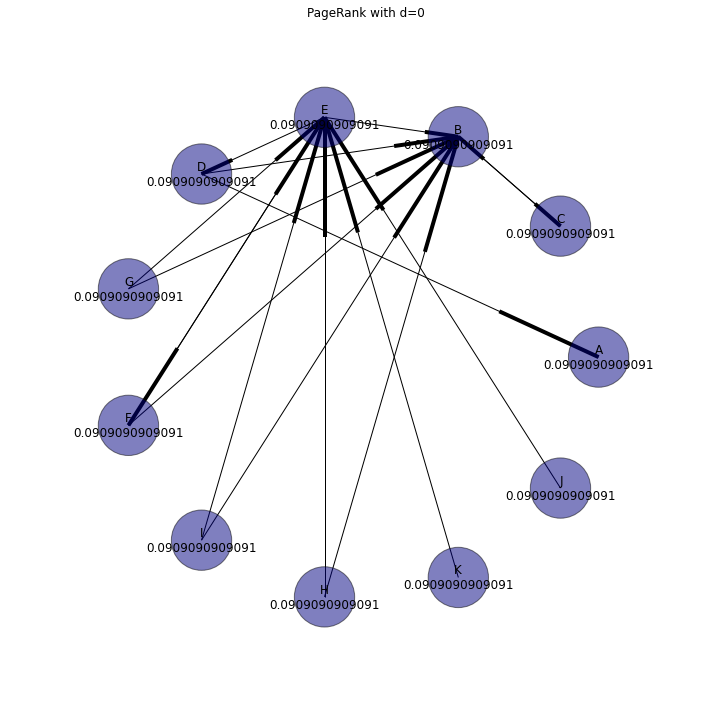

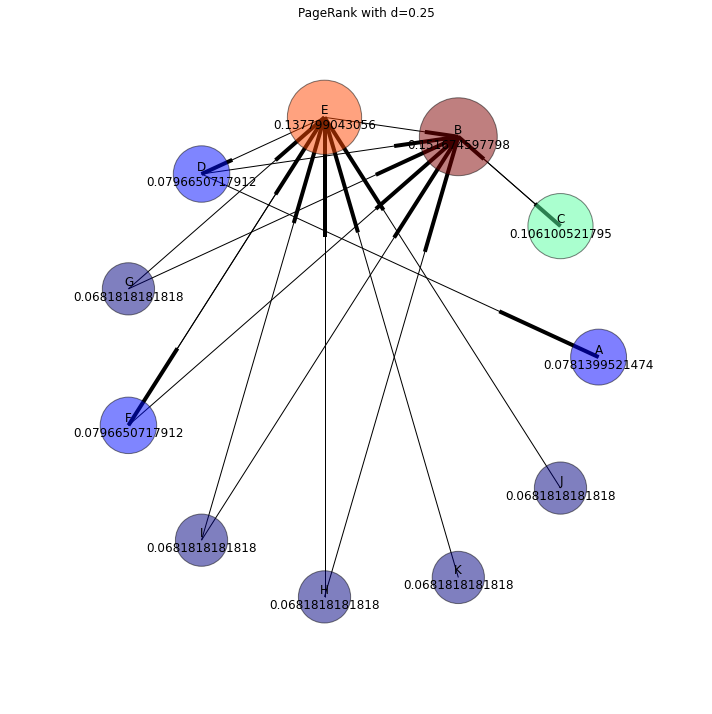

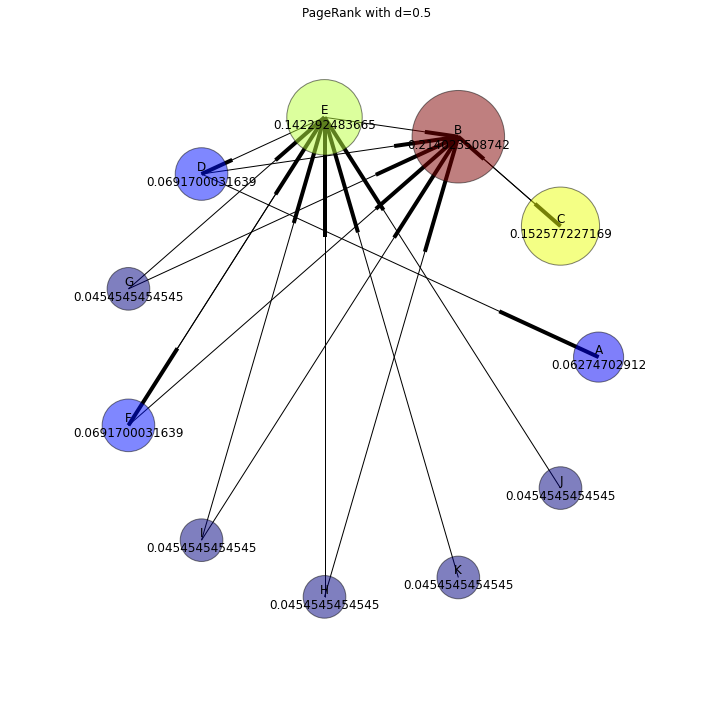

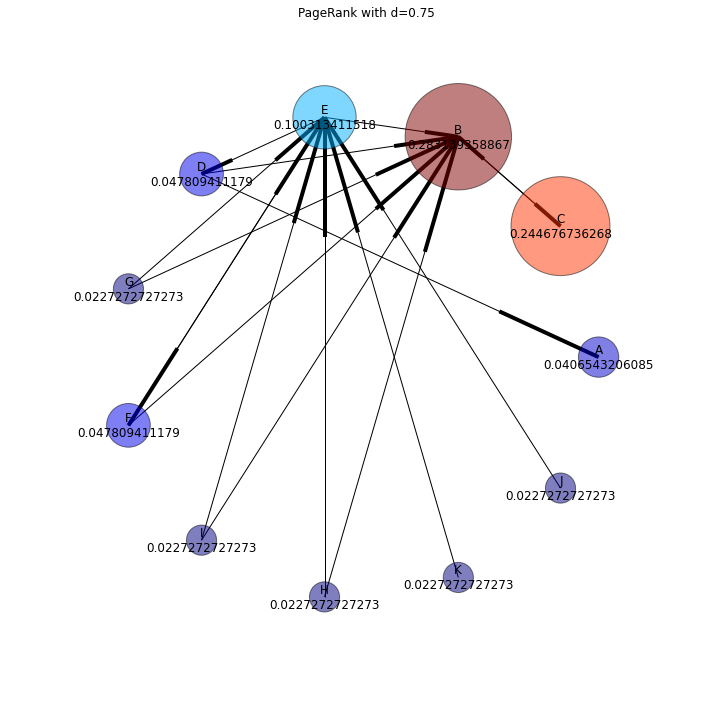

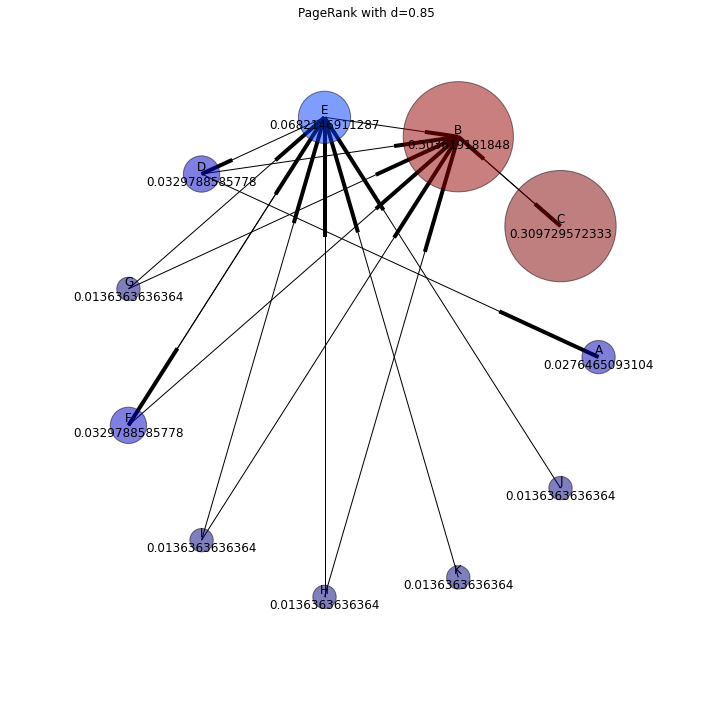

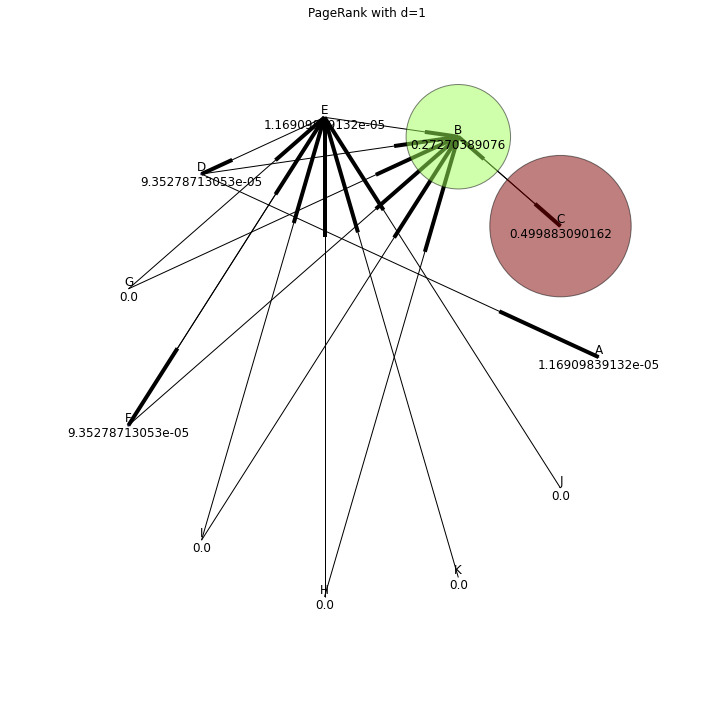

In [10]:
%matplotlib inline
import networkx as nx
import ast
from matplotlib import pyplot as plt

# Draw graphs
def draw(edges, scores, d):
    plt.figure(figsize=(10, 10))

    # initialize directed graph
    DG = nx.DiGraph()

    # add edges
    for edge in edges:
        DG.add_edge(edge[0], edge[1])    
    
    node_size = [scores[n]*40000 for n in DG.nodes()]

    graph_pos = nx.circular_layout(DG)

    # set labels
    labels = {}    
    for node in DG.nodes():
        labels[node] = '{}\n{}'.format(node, scores[node])

    # draw graph
    nx.draw_networkx_nodes(DG, graph_pos, node_size = node_size, node_color=node_size, alpha = 0.5)
    nx.draw_networkx_edges(DG, graph_pos, edge_color = 'black', arrows = True)
    nx.draw_networkx_labels(DG, graph_pos, labels=labels, font_size = 12)

    # show graph
    plt.title("PageRank with d={}".format(d))
    plt.axis('off')
    plt.tight_layout()
    plt.show()    

# Take filename, damping factor as input to produce plots by drawing graphs
def plot(f, d):
    edges = []
    scores = {}
    
    for line in open(f).read().strip().split('\n'):
        nid, nodes_score = line.split('\t') # Parse the line into the main node id and the nodes_score string
        
        nid = nid.replace('"', '') # Remove double quotes from node name
        
        nodes, score = map(ast.literal_eval, nodes_score.strip('"').split('|')) # Parse nodes_score string into nodes and score
        
        edges.extend([(nid, n) for n in nodes.keys()]) # For each node in nodes, add an edge from main node id
        scores[nid] = score # Set the score for the main node id
        
    draw(edges, scores, d) # Send our edges and scores and damping factor to the final draw function

D = [0, 0.25, 0.5, 0.75, 0.85, 1]
    
for d in D:
    f = '92d{}.txt'.format(d)
    plot(f, d)

##HW 9.3

###HW 9.3 - Problem Statement

Run your PageRank implementation on the Wikipedia dataset for 5 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Have the top 100 ranked pages changed? Comment on your findings. Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  

##HW 9.4

###9.4 - Problem Statement
Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described [here](http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf).

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the randomly generated network of 100 nodes (called randNet.txt) which are organized into ten topics, as described in the file randNet_topics.txt 

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:

vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj

for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes. If beta > 0.5, PageRank is topic-sensitive, and if beta < 0.5, the PageRank is anti-topic-sensitive. For any value of beta irreducibility should hold,so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.

##End of Submission